<a href="https://colab.research.google.com/github/ElenaShargina/nnetworks/blob/main/(8)_%D0%A1%D0%B5%D1%82%D1%8C_%D0%B4%D0%BB%D1%8F_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0_%D0%BE%D1%82%D0%B7%D1%8B%D0%B2%D0%BE%D0%B2_%D0%BD%D0%B0_%D1%84%D0%B8%D0%BB%D1%8C%D0%BC%D1%8B_%D0%B8_%D0%B8%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B5%D1%91_%D0%B4%D0%BB%D1%8F_%D0%BE%D1%82%D0%B7%D1%8B%D0%B2%D0%BE%D0%B2_%D0%BD%D0%B0_%D0%BA%D0%BD%D0%B8%D0%B3%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Сеть будет обучена на отзывах на фильмы IMDB и будет решать задачу бинарной классификации (хороший/плохой фильм). После этого попробуем её применить к отзывам на книги Amazon. В обоих случаях будем использовать англоязычные отзывы. 

In [ ]:
from typing import List, Dict
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, LSTM 
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
%matplotlib inline 

# Подготовка и обзор данных IMDB

In [ ]:
# будем брать только самые популярные 10 000 слов, остальные игнорируем
max_words=10_000

In [ ]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words)

Просмотрим пример данных

In [ ]:
n = 100
x_train[n]

[1,
 13,
 244,
 6,
 87,
 337,
 7,
 628,
 2219,
 5,
 28,
 285,
 15,
 240,
 93,
 23,
 288,
 549,
 18,
 1455,
 673,
 4,
 241,
 534,
 3635,
 8448,
 20,
 38,
 54,
 13,
 258,
 46,
 44,
 14,
 13,
 1241,
 7258,
 12,
 5,
 5,
 51,
 9,
 14,
 45,
 6,
 762,
 7,
 2,
 1309,
 328,
 5,
 428,
 2473,
 15,
 26,
 1292,
 5,
 3939,
 6728,
 5,
 1960,
 279,
 13,
 92,
 124,
 803,
 52,
 21,
 279,
 14,
 9,
 43,
 6,
 762,
 7,
 595,
 15,
 16,
 2,
 23,
 4,
 1071,
 467,
 4,
 403,
 7,
 628,
 2219,
 8,
 97,
 6,
 171,
 3596,
 99,
 387,
 72,
 97,
 12,
 788,
 15,
 13,
 161,
 459,
 44,
 4,
 3939,
 1101,
 173,
 21,
 69,
 8,
 401,
 2,
 4,
 481,
 88,
 61,
 4731,
 238,
 28,
 32,
 11,
 32,
 14,
 9,
 6,
 545,
 1332,
 766,
 5,
 203,
 73,
 28,
 43,
 77,
 317,
 11,
 4,
 2,
 953,
 270,
 17,
 6,
 3616,
 13,
 545,
 386,
 25,
 92,
 1142,
 129,
 278,
 23,
 14,
 241,
 46,
 7,
 158]

В IMDB используется частнотное кодирование слов. Для удобства "перевернем" его словарь, поменяв значения и ключи местами.

In [ ]:
word_index = imdb.get_word_index()
word_index_reversed = {value:key for key,value in word_index.items()} 
word_index_reversed

{34701: 'fawn',
 52006: 'tsukino',
 52007: 'nunnery',
 16816: 'sonja',
 63951: 'vani',
 1408: 'woods',
 16115: 'spiders',
 2345: 'hanging',
 2289: 'woody',
 52008: 'trawling',
 52009: "hold's",
 11307: 'comically',
 40830: 'localized',
 30568: 'disobeying',
 52010: "'royale",
 40831: "harpo's",
 52011: 'canet',
 19313: 'aileen',
 52012: 'acurately',
 52013: "diplomat's",
 25242: 'rickman',
 6746: 'arranged',
 52014: 'rumbustious',
 52015: 'familiarness',
 52016: "spider'",
 68804: 'hahahah',
 52017: "wood'",
 40833: 'transvestism',
 34702: "hangin'",
 2338: 'bringing',
 40834: 'seamier',
 34703: 'wooded',
 52018: 'bravora',
 16817: 'grueling',
 1636: 'wooden',
 16818: 'wednesday',
 52019: "'prix",
 34704: 'altagracia',
 52020: 'circuitry',
 11585: 'crotch',
 57766: 'busybody',
 52021: "tart'n'tangy",
 14129: 'burgade',
 52023: 'thrace',
 11038: "tom's",
 52025: 'snuggles',
 29114: 'francesco',
 52027: 'complainers',
 52125: 'templarios',
 40835: '272',
 52028: '273',
 52130: 'zaniacs',

Просмотрим самые используемые и самые редкие слова.

In [ ]:
word_index_sorted = sorted(word_index_reversed.items())
# cамые часто используемые слова
print(word_index_sorted[:50])
# самые редкие слова
print(word_index_sorted[-1:-50:-1])

[(1, 'the'), (2, 'and'), (3, 'a'), (4, 'of'), (5, 'to'), (6, 'is'), (7, 'br'), (8, 'in'), (9, 'it'), (10, 'i'), (11, 'this'), (12, 'that'), (13, 'was'), (14, 'as'), (15, 'for'), (16, 'with'), (17, 'movie'), (18, 'but'), (19, 'film'), (20, 'on'), (21, 'not'), (22, 'you'), (23, 'are'), (24, 'his'), (25, 'have'), (26, 'he'), (27, 'be'), (28, 'one'), (29, 'all'), (30, 'at'), (31, 'by'), (32, 'an'), (33, 'they'), (34, 'who'), (35, 'so'), (36, 'from'), (37, 'like'), (38, 'her'), (39, 'or'), (40, 'just'), (41, 'about'), (42, "it's"), (43, 'out'), (44, 'has'), (45, 'if'), (46, 'some'), (47, 'there'), (48, 'what'), (49, 'good'), (50, 'more')]
[(88584, "'l'"), (88583, "voorhees'"), (88582, 'artbox'), (88581, 'copywrite'), (88580, "pipe's"), (88579, 'wheelers'), (88578, 'sics'), (88577, 'transacting'), (88576, 'chicatillo'), (88575, 'ev'), (88574, 'urrrghhh'), (88573, 'airsoft'), (88572, "nemesis'"), (88571, "guard's"), (88570, "'solve'"), (88569, 'odilon'), (88568, "baywatch'"), (88567, 'heraldi

Раскодируем рассматриваемый отзыв. 
0 - символ-заполнитель
1 - начало последовательности
2 - неизвестное слово

In [ ]:
def decode(s:List[int], word_index:Dict[int,str])->str:
  return ' '.join([word_index.get(code-3,'?') for code in s])

print(x_train[n]) 
print(decode(x_train[n],word_index_reversed))

[1, 13, 244, 6, 87, 337, 7, 628, 2219, 5, 28, 285, 15, 240, 93, 23, 288, 549, 18, 1455, 673, 4, 241, 534, 3635, 8448, 20, 38, 54, 13, 258, 46, 44, 14, 13, 1241, 7258, 12, 5, 5, 51, 9, 14, 45, 6, 762, 7, 2, 1309, 328, 5, 428, 2473, 15, 26, 1292, 5, 3939, 6728, 5, 1960, 279, 13, 92, 124, 803, 52, 21, 279, 14, 9, 43, 6, 762, 7, 595, 15, 16, 2, 23, 4, 1071, 467, 4, 403, 7, 628, 2219, 8, 97, 6, 171, 3596, 99, 387, 72, 97, 12, 788, 15, 13, 161, 459, 44, 4, 3939, 1101, 173, 21, 69, 8, 401, 2, 4, 481, 88, 61, 4731, 238, 28, 32, 11, 32, 14, 9, 6, 545, 1332, 766, 5, 203, 73, 28, 43, 77, 317, 11, 4, 2, 953, 270, 17, 6, 3616, 13, 545, 386, 25, 92, 1142, 129, 278, 23, 14, 241, 46, 7, 158]
? i am a great fan of david lynch and have everything that he's made on dvd except for hotel room the 2 hour twin peaks movie so when i found out about this i immediately grabbed it and and what is this it's a bunch of ? drawn black and white cartoons that are loud and foul mouthed and unfunny maybe i don't know w

In [ ]:
# ответ из обучающей выборки: 0 - плохой фильм, 1 - хороший фильм
y_train[n]

0

In [ ]:
# приведение всех отзывов к одной длине
max_len = 200
x_train = pad_sequences(x_train, maxlen = max_len, padding = 'post')
x_test = pad_sequences(x_test, maxlen = max_len, padding = 'post')
x_train[n]

array([   1,   13,  244,    6,   87,  337,    7,  628, 2219,    5,   28,
        285,   15,  240,   93,   23,  288,  549,   18, 1455,  673,    4,
        241,  534, 3635, 8448,   20,   38,   54,   13,  258,   46,   44,
         14,   13, 1241, 7258,   12,    5,    5,   51,    9,   14,   45,
          6,  762,    7,    2, 1309,  328,    5,  428, 2473,   15,   26,
       1292,    5, 3939, 6728,    5, 1960,  279,   13,   92,  124,  803,
         52,   21,  279,   14,    9,   43,    6,  762,    7,  595,   15,
         16,    2,   23,    4, 1071,  467,    4,  403,    7,  628, 2219,
          8,   97,    6,  171, 3596,   99,  387,   72,   97,   12,  788,
         15,   13,  161,  459,   44,    4, 3939, 1101,  173,   21,   69,
          8,  401,    2,    4,  481,   88,   61, 4731,  238,   28,   32,
         11,   32,   14,    9,    6,  545, 1332,  766,    5,  203,   73,
         28,   43,   77,  317,   11,    4,    2,  953,  270,   17,    6,
       3616,   13,  545,  386,   25,   92, 1142,  1

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_train)
print(y_train)

(25000, 200)
(25000,)
[[   5   25  100 ...   19  178   32]
 [   1  194 1153 ...    0    0    0]
 [   1   14   47 ...    0    0    0]
 ...
 [   1   11    6 ...    0    0    0]
 [   1 1446 7079 ...    0    0    0]
 [   1   17    6 ...    0    0    0]]
[1 0 0 ... 0 1 0]


# Создание нейронной сети

In [ ]:
model = Sequential()
model.add(Embedding(max_words, 64, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 200, 64)           640000    
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


## Обучение нейронной сети

In [ ]:
history = model.fit(x_train, 
                    y_train, 
                    epochs=10,
                    batch_size=128,
                    validation_split=0.1)

Epoch 1/10
176/176 [==============================] - 28s 143ms/step - loss: 0.5486 - accuracy: 0.7013 - val_loss: 0.3562 - val_accuracy: 0.8568
Epoch 2/10
176/176 [==============================] - 15s 85ms/step - loss: 0.3025 - accuracy: 0.8884 - val_loss: 0.3103 - val_accuracy: 0.8804
Epoch 3/10
176/176 [==============================] - 11s 65ms/step - loss: 0.2171 - accuracy: 0.9236 - val_loss: 0.3294 - val_accuracy: 0.8788
Epoch 4/10
176/176 [==============================] - 7s 37ms/step - loss: 0.1751 - accuracy: 0.9435 - val_loss: 0.3369 - val_accuracy: 0.8736
Epoch 5/10
176/176 [==============================] - 6s 33ms/step - loss: 0.1448 - accuracy: 0.9543 - val_loss: 0.3601 - val_accuracy: 0.8700
Epoch 6/10
176/176 [==============================] - 4s 24ms/step - loss: 0.1288 - accuracy: 0.9608 - val_loss: 0.4114 - val_accuracy: 0.8716
Epoch 7/10
176/176 [==============================] - 3s 17ms/step - loss: 0.0984 - accuracy: 0.9717 - val_loss: 0.4789 - val_accuracy: 0.

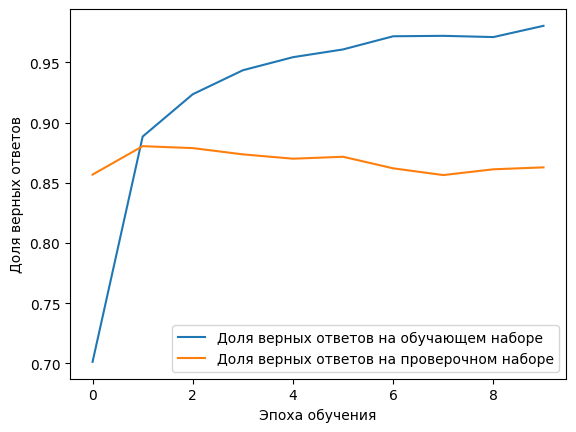

In [ ]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Проверяем работу сети на тестовом наборе данных IMDB

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

782/782 [==============================] - 4s 5ms/step - loss: 0.5361 - accuracy: 0.8538
Доля верных ответов на тестовых данных, в процентах: 85.376


# Подготовка и обзор данных с Amazon

In [ ]:
amazon_data_path = 'https://www.dropbox.com/s/2ynngq21bmkju5w/all_kindle_review%20.csv?dl=1'
data = pd.read_csv(amazon_data_path, sep=',')
data.head()

,Unnamed: 0,asin,helpful,rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,11539,B0033UV8HI,"[8, 10]",3,"Jace Rankin may be short, but he's nothing to ...","09 2, 2010",A3HHXRELK8BHQG,Ridley,Entertaining But Average,1283385600
1,5957,B002HJV4DE,"[1, 1]",5,Great short read. I didn't want to put it dow...,"10 8, 2013",A2RGNZ0TRF578I,Holly Butler,Terrific menage scenes!,1381190400
2,9146,B002ZG96I4,"[0, 0]",3,I'll start by saying this is the first of four...,"04 11, 2014",A3S0H2HV6U1I7F,Merissa,Snapdragon Alley,1397174400
3,7038,B002QHWOEU,"[1, 3]",3,Aggie is Angela Lansbury who carries pocketboo...,"07 5, 2014",AC4OQW3GZ919J,Cleargrace,very light murder cozy,1404518400
4,1776,B001A06VJ8,"[0, 1]",4,I did not expect this type of book to be in li...,"12 31, 2012",A3C9V987IQHOQD,Rjostler,Book,1356912000


Преобразуем полученную выборку. Нас интересует только текст отзыва (reviewText) и рейтинг (rating)

In [ ]:
data = data[['reviewText', 'rating']]
data.head()

,reviewText,rating
0,"Jace Rankin may be short, but he's nothing to ...",3
1,Great short read. I didn't want to put it dow...,5
2,I'll start by saying this is the first of four...,3
3,Aggie is Angela Lansbury who carries pocketboo...,3
4,I did not expect this type of book to be in li...,4


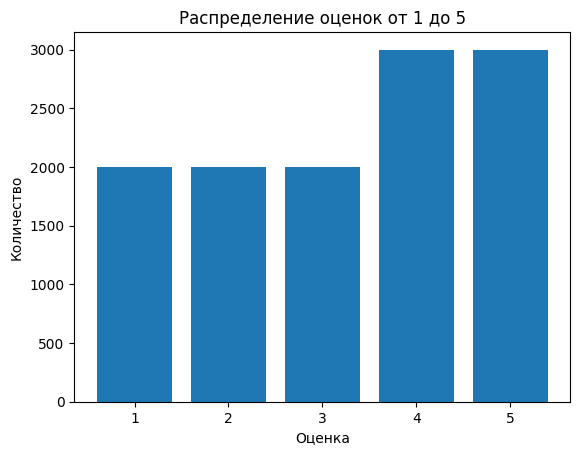

In [ ]:
rating_value_counts = data.rating.value_counts()
plt.bar(rating_value_counts.index, rating_value_counts.values)
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.title("Распределение оценок от 1 до 5")
plt.show()

Преобразуем рейтинг: если он больше 3, то будем считать оценку положительной (1), иначе - отрицательной (0).

In [ ]:
data['rating'] = data['rating'].apply(lambda x: 1 if x >3 else 0)
data.head()

,reviewText,rating
0,"Jace Rankin may be short, but he's nothing to ...",0
1,Great short read. I didn't want to put it dow...,1
2,I'll start by saying this is the first of four...,0
3,Aggie is Angela Lansbury who carries pocketboo...,0
4,I did not expect this type of book to be in li...,1


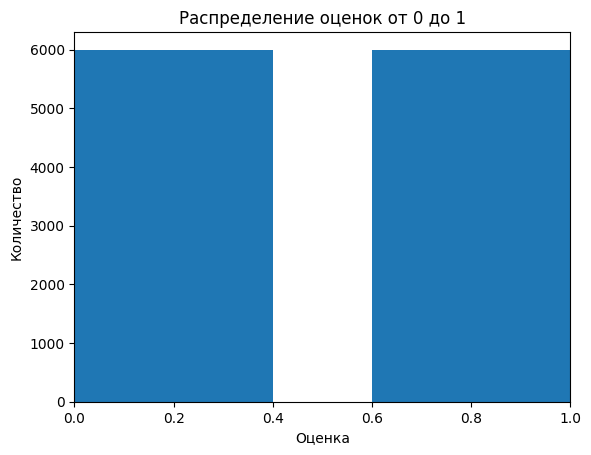

In [ ]:
rating_value_counts = data.rating.value_counts()
plt.bar(rating_value_counts.index, rating_value_counts.values)
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.title("Распределение оценок от 0 до 1")
plt.xlim(0,1)
plt.show()

Просмотр одного отзыва на книгу до преобразования текстов.

In [ ]:
n = 100
print(data['reviewText'][n])

This is one of my favorite authors. Sometimes it's predictable but she always adds an extra twist to all of her books. This was a fun read,had all the elements for a good  book, humor, sex and fascinating characters. A great love story.


In [ ]:
# переводим весь текст в нижний регистр
data['reviewText'] = data['reviewText'].str.lower()
# убираем пуктуацию
punctuation = string.punctuation
def remove_punctuation(s:str, punctuation:str)->str:
    return s.translate(str.maketrans('', '', punctuation))
data['reviewText'] = data['reviewText'].apply(lambda x: remove_punctuation(x, punctuation))
print(data['reviewText'][n])

this is one of my favorite authors sometimes its predictable but she always adds an extra twist to all of her books this was a fun readhad all the elements for a good  book humor sex and fascinating characters a great love story


In [ ]:
# закодируем слова в отзывах с помощью частотного словаря из imdb
def code(x:string, word_index:Dict[str,int], max_words:int) -> List[int]:
  words = x.split()
  result = []
  for i in words:
    c = word_index.get(i,2)
    if c < max_words:
      result.append(c)
  return result

data['reviewText'] = data['reviewText'].apply(lambda x: code(x, word_index, max_words))
print(data['reviewText'][n])

[11, 6, 28, 4, 58, 511, 8897, 515, 91, 724, 18, 56, 207, 1605, 32, 1724, 1006, 5, 29, 4, 38, 1148, 11, 13, 3, 250, 2, 29, 1, 788, 15, 3, 49, 271, 483, 380, 2, 1426, 102, 3, 84, 116, 62]


In [ ]:
# приведение всех отзывов к одной длине
x_amazon = np.array(data['reviewText'])
x_amazon = pad_sequences(x_amazon, maxlen = max_len, padding = 'post')

y_amazon = np.array(data['rating'])

print(x_amazon.shape)
print(y_amazon.shape)

(12000, 200)
(12000,)


# Применение обученной модели на данных с Amazon

In [ ]:
scores = model.evaluate(x_amazon, y_amazon, verbose=1)
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

375/375 [==============================] - 2s 5ms/step - loss: 2.2077 - accuracy: 0.5039
Доля верных ответов на тестовых данных, в процентах: 50.3917


# Обзор полученного векторного представления слов

In [ ]:
embedding_matrix = model.layers[0].get_weights()[0]

word_index_original = imdb.get_word_index()

word_index = {word:number+3 for word, number in word_index_original.items()}

word_index["<Заполнитель>"] = 0
word_index["<Начало последовательности>"] = 1
word_index["<Неизвестное слово>"] = 2  
word_index["<Не используется>"] = 3

Посмотрим векторное представление слова good.

In [ ]:
word = 'good'
word_number = word_index[word]
print(embedding_matrix[word_number])

[-0.04620266  0.03390115  0.0820526   0.04993058 -0.08888461 -0.06386176
  0.06542788 -0.05537656  0.08415169  0.00681198  0.00307846 -0.00547379
 -0.06001289  0.01416244 -0.07416343  0.06947254  0.03476863 -0.05109727
  0.06213843 -0.00061847 -0.03312873 -0.03910231  0.0917983  -0.08010557
  0.00818309  0.07236587  0.08570185  0.00066725  0.04697857  0.06620362
  0.09082438 -0.03790497 -0.05624393 -0.03091418 -0.08192475 -0.02639001
 -0.10318334  0.08876148 -0.06381568  0.05368574  0.04092956  0.09276092
 -0.05853343 -0.11789771  0.03515069  0.04322964  0.04618418 -0.00086582
 -0.03456967 -0.00569266 -0.09946513 -0.0033105  -0.01403128  0.07666038
 -0.0262143  -0.08473971  0.06404854 -0.01553322  0.10093881  0.05308111
  0.00580293  0.0525386  -0.09264041 -0.09848721]


Посмотрим векторное представление слова bad.

In [ ]:
word = 'bad'
word_number = word_index[word]
print(embedding_matrix[word_number])

[ 0.03089172 -0.11570168 -0.09352098 -0.10367393  0.12361501  0.13441873
 -0.13340823  0.02329914 -0.07280995 -0.1444623  -0.06495313  0.10730734
  0.13126433 -0.15167384  0.06322332 -0.10825973 -0.07991289  0.06522885
 -0.03419497  0.05805792  0.07026318  0.13372763 -0.09880742  0.11328617
 -0.09671199 -0.13748418 -0.14020051  0.11266607 -0.14035656 -0.0235225
 -0.11706652  0.0641745   0.08873566  0.04619613  0.02936163  0.03667536
  0.09993113 -0.08194831  0.09110584 -0.08595417 -0.09249128 -0.05952194
  0.04687759  0.02819361 -0.04726855 -0.12397696 -0.10427697  0.10565744
  0.11280249  0.09865875 -0.00295603  0.14442451 -0.02629938  0.04959628
  0.08194795  0.10630918 -0.06311621  0.07695711 -0.05156957 -0.06643793
 -0.13454084 -0.10281438  0.13240299  0.02070147]


Посмотрим на графике, как расположены ярко окрашенные по эмоциональности слова.

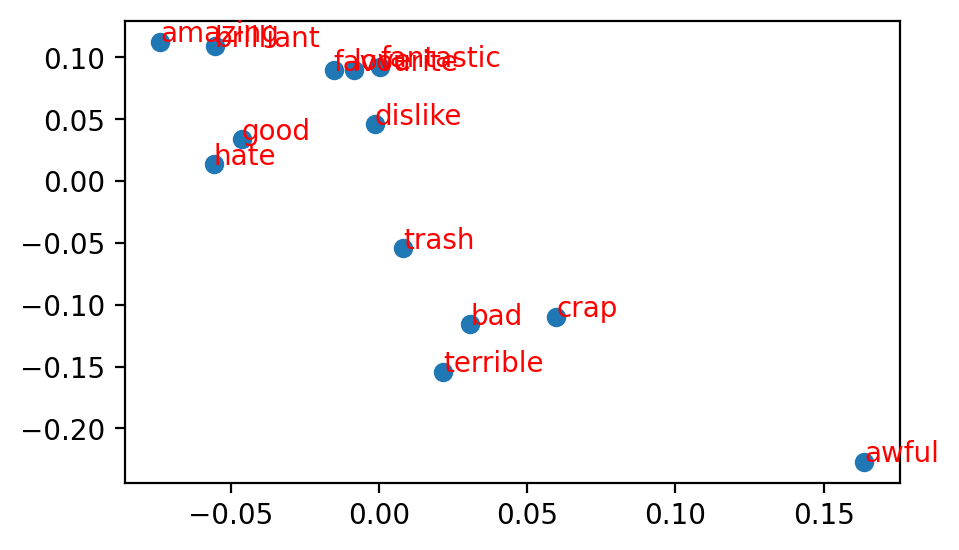

In [ ]:
words = ['brilliant', 'fantastic', 'amazing', 'good', 'love', 'favourite',
          'bad', 'awful','crap', 'terrible', 'trash', 'hate', 'dislike']

word_vectors = embedding_matrix[[word_index[i] for i in words]]

plt.figure(figsize=(5, 3), dpi=200, facecolor='w')
plt.scatter(word_vectors[:,0], word_vectors[:,1])
for i, txt in enumerate(words):
    plt.annotate(txt, (word_vectors[i,0], word_vectors[i,1]), color='r')